In [1]:
#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Function to convert lat distance to meters

def latToMeter(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a));
    d = R * c;
    return d * 1000; # meters

#Function to convert dB to meters

def dbToMeter(RSSI, measure_ref, N):
    d = 10**((measure_ref - RSSI)/(10 * N))
    return d

In [3]:
#Defining beacon's ids + gateways/relays ids

beaconNames = ['e2:30:d3:c9:fb:66', 'e2:51:e0:31:ee:0e', 'beacon_C', 'beacon_D', 'beacon_E']
relayNames = ['relay_1', 'relay_2', 'relay_3', 'relay_4', 'relay_5']

#Defining the geographical coordinates of each gateway

relay_df = pd.DataFrame(index=['lat','long'], columns=relayNames)

relay_df.loc['long'] = [6.589019688234726, 6.588961543484985, 6.589073482115638, np.nan, np.nan]
relay_df.loc['lat'] = [46.52591575091452, 46.526014238558744, 46.525974983352235, np.nan, np.nan]

relay_df

,relay_1,relay_2,relay_3,relay_4,relay_5
lat,46.5259,46.526,46.526,NaN,NaN
long,6.58902,6.58896,6.58907,NaN,NaN


In [4]:
#Setting the df for the first relay (what it detected)

relay1 = pd.DataFrame(index=['RSSI','tx','ref'], columns=beaconNames)

relay1.loc['RSSI'] = [-94, np.nan, np.nan, np.nan, np.nan]
relay1.loc['tx'] = [4, np.nan, np.nan, np.nan, np.nan]
relay1.loc['ref']=[-69, np.nan, np.nan, np.nan, np.nan]
relay1.loc['dist'] = dbToMeter(relay1.loc['RSSI'], relay1.loc['ref'], relay1.loc['tx'])


#Setting the df for the relay n°2 (what it detected)

relay2 = pd.DataFrame(columns=beaconNames)

relay2.loc['RSSI'] = [-88, -70, np.nan, np.nan, np.nan]
relay2.loc['tx'] = [4, 4, np.nan, np.nan, np.nan]
relay2.loc['ref'] = [-69, -69, np.nan, np.nan, np.nan]
relay2.loc['dist'] = dbToMeter(relay2.loc['RSSI'], relay2.loc['ref'], relay2.loc['tx'])

#Setting the df for the gateway n°3 (what it detected)

relay3 = pd.DataFrame(index=['RSSI','tx','ref'], columns=beaconNames)

relay3.loc['RSSI'] = [np.nan, -89, np.nan, np.nan, np.nan]
relay3.loc['tx'] = [np.nan, 4, np.nan, np.nan, np.nan]
relay3.loc['ref']=[np.nan, -69, np.nan, np.nan, np.nan]
relay3.loc['dist'] = dbToMeter(relay3.loc['RSSI'], relay3.loc['ref'], relay3.loc['tx'])

print("As example: ")
relay3

As example: 


,e2:30:d3:c9:fb:66,e2:51:e0:31:ee:0e,beacon_C,beacon_D,beacon_E
RSSI,NaN,-89,NaN,NaN,NaN
tx,NaN,4,NaN,NaN,NaN
ref,NaN,-69,NaN,NaN,NaN
dist,NaN,3.16228,NaN,NaN,NaN


In [5]:
#Creating a connectivity matrix between what the beacon and the gateways

connectivity_df = pd.DataFrame(index=beaconNames, columns=relayNames)

connectivity_df[relayNames[0]] = relay1.loc['dist']
connectivity_df[relayNames[1]] = relay2.loc['dist']
connectivity_df[relayNames[2]] = relay3.loc['dist']
connectivity_df

,relay_1,relay_2,relay_3,relay_4,relay_5
e2:30:d3:c9:fb:66,4.21697,2.985383,NaN,NaN,NaN
e2:51:e0:31:ee:0e,NaN,1.059254,3.16228,NaN,NaN
beacon_C,NaN,NaN,NaN,NaN,NaN
beacon_D,NaN,NaN,NaN,NaN,NaN
beacon_E,NaN,NaN,NaN,NaN,NaN


In [6]:
#With history

df = pd.DataFrame({"Status": ["A","A","B","B","C","C","C"]})
df["isStatusChanged"] = df["Status"].shift(1, fill_value=df["Status"].head(1)) != df["Status"]
df.iloc[0:5,:]

,Status,isStatusChanged
0,A,False
1,A,False
2,B,True
3,B,False
4,C,True


In [7]:
#With event detail

event_detail = "relay_1"
updated_beacon = connectivity_df[~connectivity_df.loc[:,event_detail].isnull()].index

updated_beacon

Index(['e2:30:d3:c9:fb:66'], dtype='object')

In [8]:
position_df = pd.DataFrame(index=beaconNames, columns=['Lat', 'Long']) #The output df

#Triangulation of each beacon 

for i in range (len(updated_beacon)):  #len(beaconNames)
    
    print(updated_beacon[i])  
    
     #Defining a temporary df for the data of the beacon
    temp_df = pd.DataFrame(connectivity_df.loc[beaconNames[i],:][connectivity_df.loc[beaconNames[i],:]>0])
    temp_df = temp_df.reset_index().rename(columns={'index': 'relay', beaconNames[i]:"dist"})
    temp_df = temp_df.sort_values("dist", axis=0, ascending= True).iloc[0:5,:] #We'll only use the 5 closest relays to the beacon
    
    print(temp_df, "\n")
     
    #Case where multiple relays detect the beacon
    
    lat = []
    long = []
    
    if len(temp_df) > 1:
        
        for relay_1 in range(len(temp_df)-1):
            
            
            
            for relay_2 in range (relay_1+1, len(temp_df)):
                
                #Making a vector between the 2 gateways
                vect_lat = relay_df.loc["lat" ,temp_df.loc[relay_2,"relay"]] - relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]]            
                vect_long = relay_df.loc["long" ,temp_df.loc[relay_2,"relay"]] - relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]]
                
                #Calculating the distance between the 2 gateways in meter
                dist = latToMeter(relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]], relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]],
                       relay_df.loc["lat" ,temp_df.loc[relay_2,"relay"]], relay_df.loc["long" ,temp_df.loc[relay_2,"relay"]])
                
                print("Measuring distance between", temp_df.iloc[relay_1, 0], "and", temp_df.iloc[relay_2, 0], ":", dist)
                
                #Applying proportionality rule from the origin on the vector to determine the position of the beacon in lat;long coord
                #ie: x1 = x0 + (dist_beacon/dist_tot) * vector_length            
                
                lat.append(relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]] + (temp_df.loc[relay_1, "dist"] / dist)*vect_lat)
                long.append(relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]] + (temp_df.loc[relay_1, "dist"] / dist)*vect_long)
                
        position_df.loc[beaconNames[i], "Lat"] = np.mean(lat)
        position_df.loc[beaconNames[i], "Long"] = np.mean(long)
        print(lat, long)
        #temp_df.loc[]
        print("\n\n ---------- \n \n")
    
    #Case where only one relay detects the beacon
    elif len(temp_df) == 1:
        
        position_df.loc[beaconNames[i], "Lat"] = relay_df.loc["lat" ,temp_df.loc[0,"relay"]]
        position_df.loc[beaconNames[i], "Long"] = relay_df.loc["long" ,temp_df.loc[0,"relay"]]
        
        print("Only dectected once, !! low accuracy !!")
        print("\n\n ---------- \n \n")
        
    #Case where     
    else:
        
        position_df.loc[beaconNames[i], "Lat"] = np.nan
        position_df.loc[beaconNames[i], "Long"] = np.nan
        print("Not detected")
        print("\n\n ---------- \n \n")
        
print(position_df)

e2:30:d3:c9:fb:66
     relay     dist
1  relay_2  2.98538
0  relay_1  4.21697 

Measuring distance between relay_2 and relay_1 : 11.833540978847859
[46.525950847674885] [6.588998967946773]


 ---------- 
 

                      Lat   Long
e2:30:d3:c9:fb:66  46.526  6.589
e2:51:e0:31:ee:0e     NaN    NaN
beacon_C              NaN    NaN
beacon_D              NaN    NaN
beacon_E              NaN    NaN


<function matplotlib.pyplot.show(close=None, block=None)>

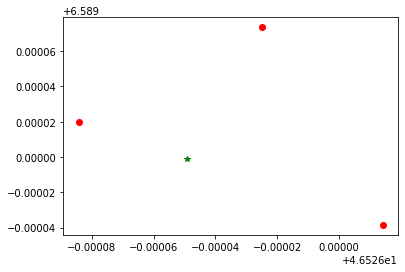

In [9]:
plt.plot()
plt.plot(relay_df.loc['lat'], relay_df.loc['long'],'ro', position_df.Lat, position_df.Long,'g*')
plt.show

### Python code to implement

In [10]:
#Functions

#Function to convert lat distance to meters

def latToMeter(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180;
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180;
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2);
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a));
    d = R * c;
    return d * 1000; # meters

#Function to convert dB to meters

def dbToMeter(RSSI, measure_ref, N):
    d = 10**((measure_ref - RSSI)/(10 * N))
    return d

In [12]:
### Python code

#Importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#With event detail

event_detail = "relay_2"
updated_beacon = connectivity_df[~connectivity_df.loc[:,event_detail].isnull()].index

updated_beacon

position_df = pd.DataFrame(index=beaconNames, columns=['Lat', 'Long']) #The output df

#Triangulation of each beacon 

for i in range (len(updated_beacon)):  #len(beaconNames) 
    
     #Defining a temporary df for the data of the beacon
    temp_df = pd.DataFrame(connectivity_df.loc[beaconNames[i],:][connectivity_df.loc[beaconNames[i],:]>0])
    temp_df = temp_df.reset_index().rename(columns={'index': 'relay', beaconNames[i]:"dist"})
    temp_df = temp_df.sort_values("dist", axis=0, ascending= True).iloc[0:5,:] #We'll only use the 5 closest relays to the beacon
     
    #Case where multiple relays detect the beacon
    
    lat = []
    long = []
    
    if len(temp_df) > 1:
        
        for relay_1 in range(len(temp_df)-1):
            
            
            
            for relay_2 in range (relay_1+1, len(temp_df)):
                
                #Making a vector between the 2 gateways
                vect_lat = relay_df.loc["lat" ,temp_df.loc[relay_2,"relay"]] - relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]]            
                vect_long = relay_df.loc["long" ,temp_df.loc[relay_2,"relay"]] - relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]]
                
                #Calculating the distance between the 2 gateways in meter
                dist = latToMeter(relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]], relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]],
                       relay_df.loc["lat" ,temp_df.loc[relay_2,"relay"]], relay_df.loc["long" ,temp_df.loc[relay_2,"relay"]])
                
                #Applying proportionality rule from the origin on the vector to determine the position of the beacon in lat;long coord
                #ie: x1 = x0 + (dist_beacon/dist_tot) * vector_length            
                
                lat.append(relay_df.loc["lat" ,temp_df.loc[relay_1,"relay"]] + (temp_df.loc[relay_1, "dist"] / dist)*vect_lat)
                long.append(relay_df.loc["long" ,temp_df.loc[relay_1,"relay"]] + (temp_df.loc[relay_1, "dist"] / dist)*vect_long)
                
        position_df.loc[beaconNames[i], "Lat"] = np.mean(lat)
        position_df.loc[beaconNames[i], "Long"] = np.mean(long)
        
    #Case where only one relay detects the beacon
    elif len(temp_df) == 1:
        
        print("Only dectected once, !! low accuracy !!")
        print("\n\n ---------- \n \n")
        
    #Case where     
    else:
        print("Not detected")
        print("\n\n ---------- \n \n")
        
position_df

,Lat,Long
e2:30:d3:c9:fb:66,46.526,6.589
e2:51:e0:31:ee:0e,46.526,6.58897
beacon_C,NaN,NaN
beacon_D,NaN,NaN
beacon_E,NaN,NaN
